In [ ]:
"""
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, 
the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). 
Your project is to:
1. Predict conversion rate
2. Come up with recommendations for the product team and the marketing team to improve conversion rate
"""

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/conversion_project.csv')
##data = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/conversion_project.csv')
data.head(10)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0
6,China,27,1,Seo,4,0
7,US,23,0,Ads,4,0
8,UK,29,0,Direct,4,0
9,US,25,0,Ads,2,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


# Remove Outlier

In [5]:
data = data[data['age']<100]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316198 entries, 0 to 316199
Data columns (total 6 columns):
country                316198 non-null object
age                    316198 non-null int64
new_user               316198 non-null int64
source                 316198 non-null object
total_pages_visited    316198 non-null int64
converted              316198 non-null int64
dtypes: int64(4), object(2)
memory usage: 16.9+ MB


# Exploratory Data Analysis

## Converted VS Country

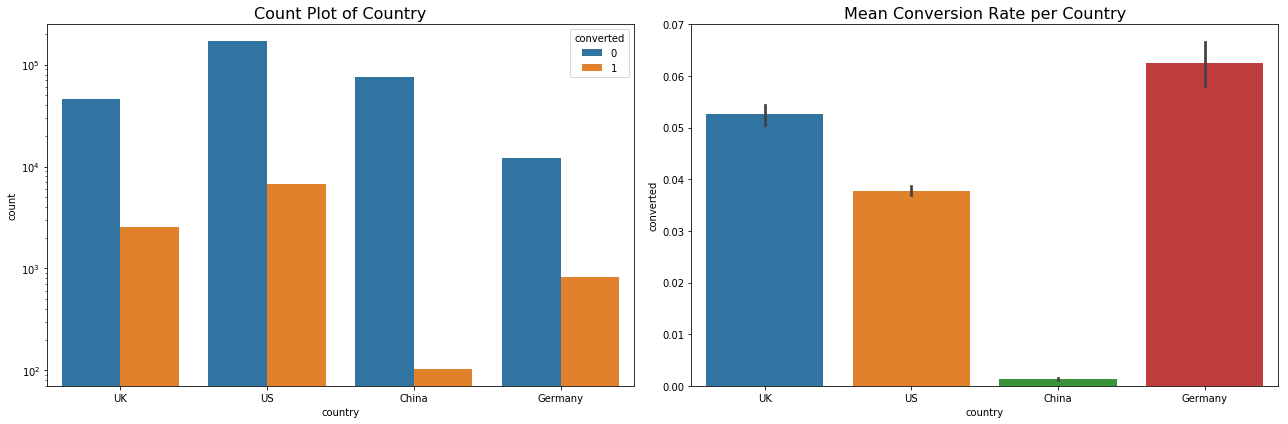

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

## Converted VS User History

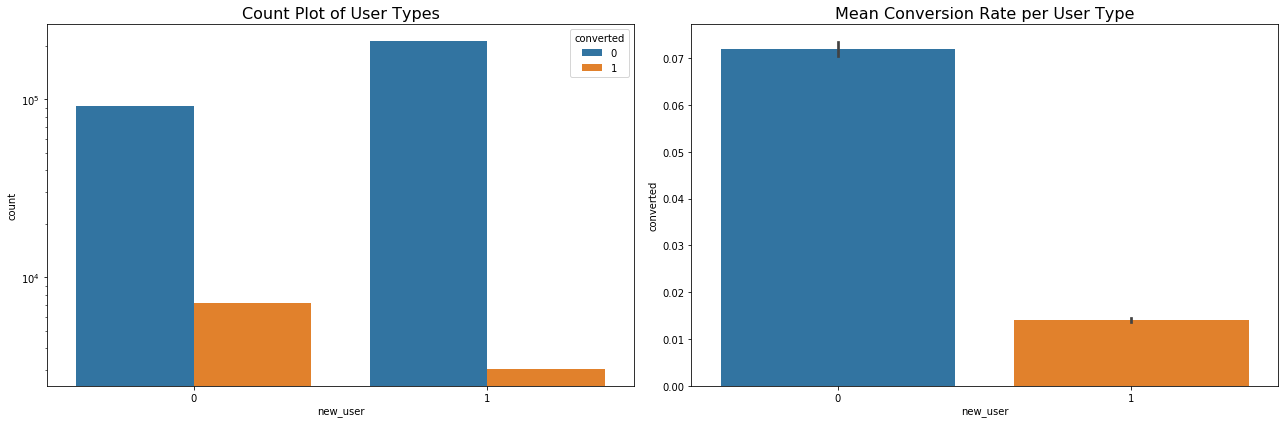

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

## Converted VS Click Source

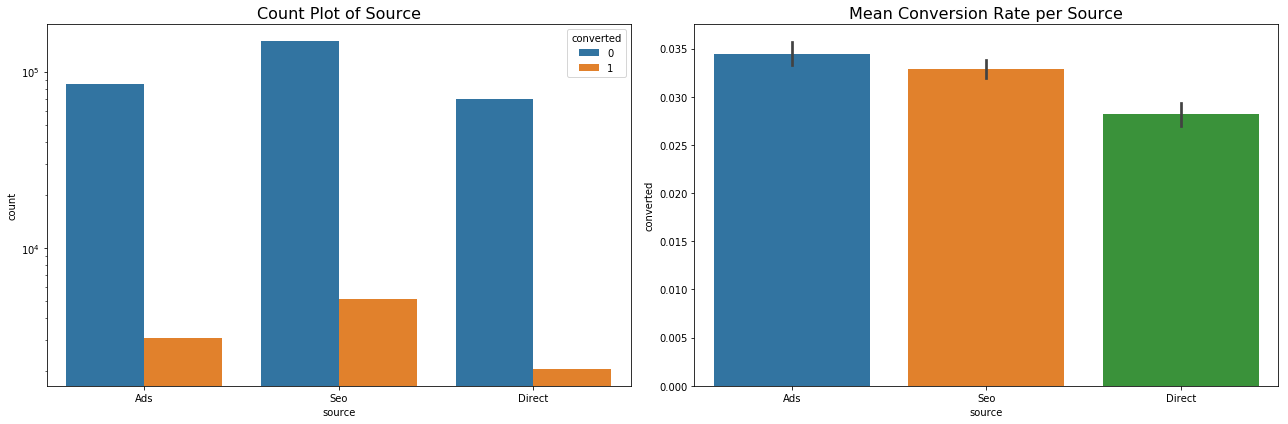

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'source', hue = 'converted', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Source', fontsize = 16)
ax[0].set_yscale('log')
sns.barplot(x='source',y='converted', data = data, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize = 16)
plt.tight_layout()
plt.show()

## Converted VS Age

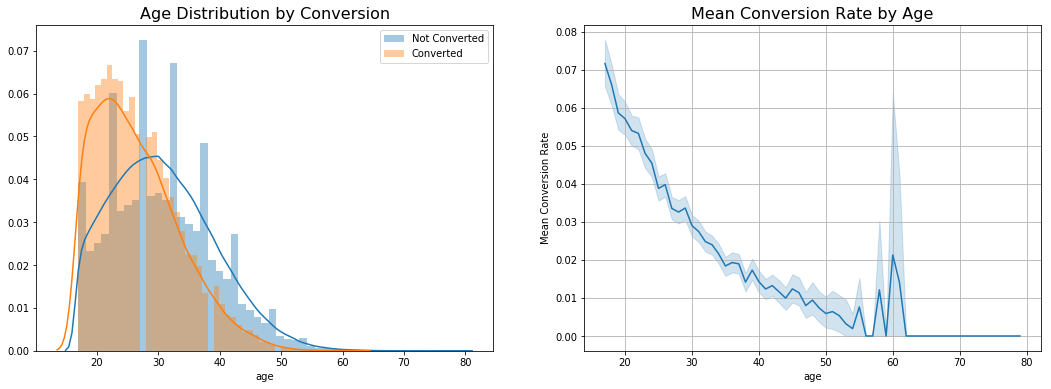

In [9]:
grouped = data[['age','converted']].groupby('age').mean().reset_index()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.distplot(data[data['converted']==0]['age'],label='Not Converted',ax=ax[0])
sns.distplot(data[data['converted']==1]['age'],label='Converted',ax=ax[0])
ax[0].set_title('Age Distribution by Conversion', fontsize = 16)
ax[0].legend()
sns.lineplot(x='age',y='converted',data=data,ax=ax[1])
ax[1].set_title('Mean Conversion Rate by Age', fontsize = 16)
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid()
plt.show()



## Converted VS Page Visited

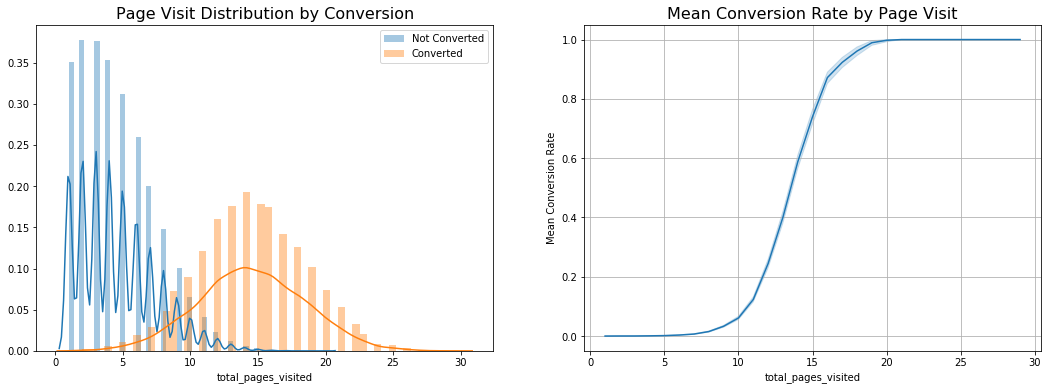

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.distplot(data[data['converted']==0]['total_pages_visited'],label='Not Converted',ax=ax[0])
sns.distplot(data[data['converted']==1]['total_pages_visited'],label='Converted',ax=ax[0])
ax[0].set_title('Page Visit Distribution by Conversion', fontsize = 16)
ax[0].legend()
sns.lineplot(x='total_pages_visited',y='converted',data=data,ax=ax[1])
ax[1].set_title('Mean Conversion Rate by Page Visit', fontsize = 16)
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid()
plt.show()

# Machine Learning

In [11]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/adamichael/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/0k/yh14kvb53z332ckrh5l_n0wr0000gn/T/tmp_41otzs6
  JVM stdout: /var/folders/0k/yh14kvb53z332ckrh5l_n0wr0000gn/T/tmp_41otzs6/h2o_adamichael_started_from_python.out
  JVM stderr: /var/folders/0k/yh14kvb53z332ckrh5l_n0wr0000gn/T/tmp_41otzs6/h2o_adamichael_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_adamichael_cau92s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [12]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [13]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)
strat_split.summary()

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

,test_train_split
type,enum
mins,
mean,
maxs,
sigma,
zeros,
missing,0
0,train
1,train
2,train


In [15]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)


drf Model Build progress: |███████████████████████████████████████████████| 100%


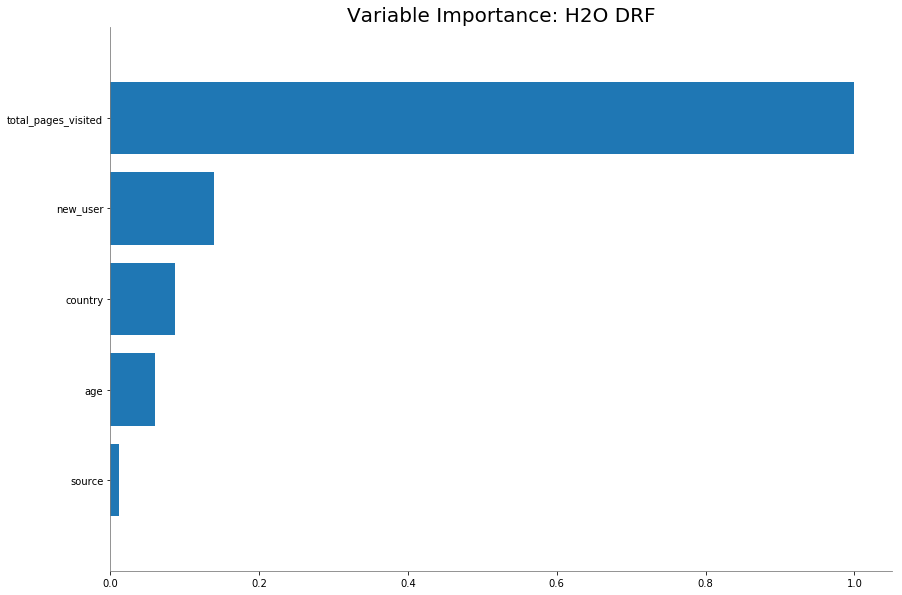

In [16]:
model.varimp_plot()

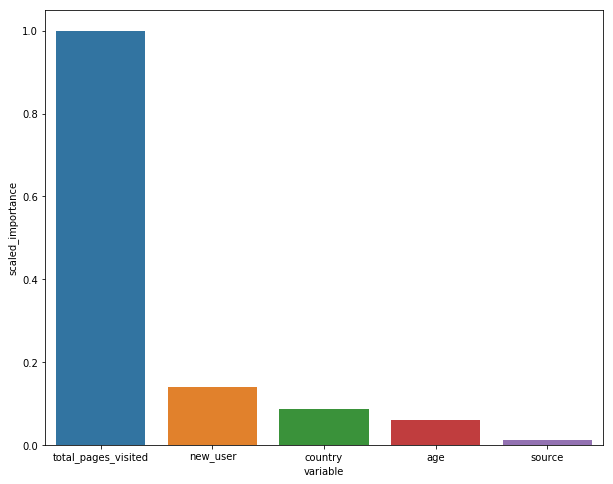

In [18]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
##sns.barplot(x='scaled_importance', y='variable', data=importance)
sns.barplot(x='variable', y='scaled importance', data=importance)
plt.show()

In [19]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [20]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

   micro avg       0.98      0.98      0.98     79050
   macro avg       0.91      0.82      0.86     79050
weighted avg       0.98      0.98      0.98     79050



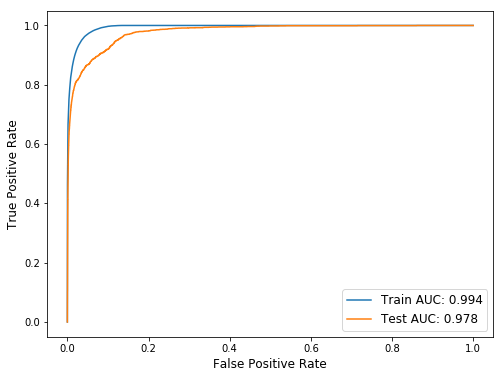

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


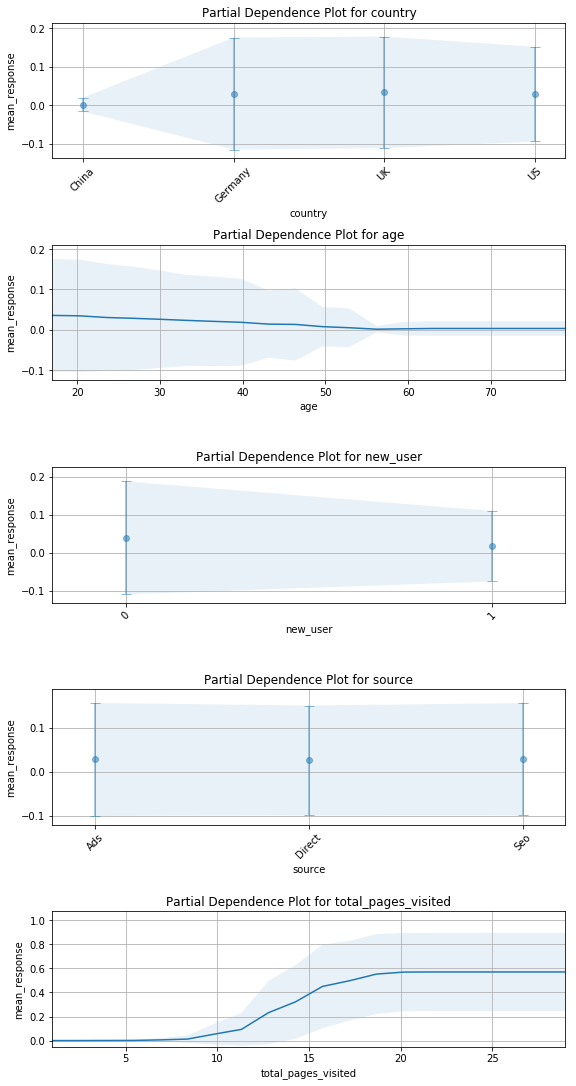

In [22]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))


In [23]:

# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_b03c closed.


In [1]:
"""
Summary:
1. By applying H2O random forest classifier, we predicted the probability of whether a customer
will be converted or not
2. The test score, compared to training score, is a bit low. To enhance the model performance, we 
need to:
(1) Increase sample size
(2) try different models
(3) further tuning parameter
3. Based on the feature performance, "total pages visit" is the most important factor. To come up with
recommendations, I would like to suggest product manager to try improving the engagement of customers.
"""

'\nSummary:\n1. By applying H2O random forest classifier, we predicted the probability of whether a customer\nwill be converted or not\n2. The test score, compared to training score, is a bit low. To enhance the model performance, we \nneed to:\n(1) Increase sample size\n(2) try different models\n(3) further tuning parameter\n3. Based on the feature performance, "total pages visit" is the most important factor. To come up with\nrecommendations, I would like to suggest product manager to try improving the engagement of customers.\n'